In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
#from mitequinox.binary import *

import xmitgcm as xm
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7)
#w = cluster.scale(jobs=10)
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.66:59824 Dashboard: http://10.148.1.66:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

# load binary grid and store as a zarr archive

### generate mask file

In [6]:
mask_data_dir = '/home/c11-data/Test_aponte/aurelien/mit/'
ds = xm.open_mdsdataset(bin_grid_dir, grid_dir=bin_grid_dir,
                        iters=None, geometry='llc',
                        default_dtype=np.dtype('>f4'),
                        read_grid=True,
                        ignore_unknown_vars=True,
                        llc_method="smallchunks")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:845: UserWarning: Couldn't find available_diagnostics.log in /home/datawork-lops-osi/equinox/mit4320/bin/grid/ or /home/datawork-lops-osi/equinox/mit4320/bin/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [8]:
points = ['C', 'S', 'W']
ds_mask = (ds.reset_coords()[['mask'+p for p in points]]
           .rename({'mask'+p: 'mask_'+p.lower() for p in points})
          )
ds_mask

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mask_c   (k, face, j, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    mask_s   (k, face, j_g, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    mask_w   (k, face, j, i_g) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/home/datawor...

In [ ]:
ds_mask.to_zarr(mask_path, mode='w', consolidated=True)

### store all but masks

In [9]:
ds = xm.open_mdsdataset(bin_grid_dir, grid_dir=bin_grid_dir,
                        iters=None, geometry='llc',
                        default_dtype=np.dtype('>f4'),
                        read_grid=True,
                        ignore_unknown_vars=True)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:845: UserWarning: Couldn't find available_diagnostics.log in /home/datawork-lops-osi/equinox/mit4320/bin/grid/ or /home/datawork-lops-osi/equinox/mit4320/bin/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [10]:
#ds_index, ds = get_compressed_level_index(grid_dir)

# we will need to keep some of these when computing gradients
#ds = ds.drop(['dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
ds = ds.drop(['hFacC','hFacW','hFacS'])
ds = ds.drop(['maskC','maskW','maskS'])
#ds = ds.drop(['Z', 'Zp1', 'Zu', 'Zl', 'drC', 'drF','PHrefC','PHrefF'])

#Nc = 432 # original choice
#Nc = 27 # very long scheduling
#Nc = 96 # 96*45
#ds = ds.chunk({'i': Nc, 'j': Nc, 'i_g': Nc, 'j_g': Nc})

print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG      

In [19]:
%time ds.to_zarr(zarr_grid, mode='w')

CPU times: user 13.8 s, sys: 48 s, total: 1min 1s
Wall time: 11.2 s


--- 

# standard data layout: chunks (face, time, j, i) = (1, 1, 4320, 4320)

In [5]:
#bpath = bin_data_dir+'Eta/'
bpath = root_data_dir+'tmp/'

fs = LocalFileSystem()
store = llcreader.BaseStore(fs, base_path=bpath, 
                            shrunk=True, mask_path=mask_path)
model = llcreader.LLC4320Model(store)

In [8]:
#V = ['Eta', 'SST', 'SSS', 'SSU', 'SSV']
V = ['oceTAUX', 'oceTAUY', 'KPPhbl']

#di = 144 # hourly values
di = 144*24 # daily values

ds = model.get_dataset(varnames=V, iter_start=228096, iter_stop=1492992+1, iter_step=di, 
                       points=['c', 'c', 'c'])
ds = ds.chunk({'face': 1})
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 367)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 dask.array<chunksize=(367,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-16 ... 2012-11-15
Data variables:
    oceTAUX  (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    oceTAUY  (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    KPPhbl   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [9]:
for v in V:
    dv = ds[v].to_dataset()
    
    file_out = zarr_dir+'%s.zarr'%(v)
    try:
        %time dv.to_zarr(file_out, mode='w')                    
    except:
        print('Failure')
        
    dsize = getsize(file_out)
    print('   data is %.1fGB ' %(dsize/1e9))    

CPU times: user 29.7 s, sys: 1.12 s, total: 30.8 s
Wall time: 1min 44s
   data is 143.8GB 
CPU times: user 22 s, sys: 860 ms, total: 22.9 s
Wall time: 58.2 s
   data is 143.6GB 
CPU times: user 20.9 s, sys: 860 ms, total: 21.8 s
Wall time: 59.6 s
   data is 144.4GB 


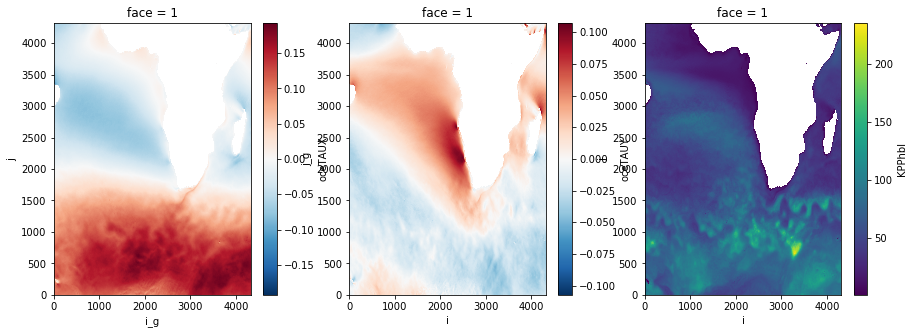

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
for v, ax in zip(V, axs):
    ds = xr.open_zarr(zarr_dir+'%s.zarr'%(v))
    ds.isel(face=1)[v].mean('time').plot(ax=ax)

---

In [ ]:
# kill scheduler, workers
cluster.close()